In [1]:
import numpy as np
import emcee   #Install following https://emcee.readthedocs.io/en/stable/user/install/
import corner   #Install following https://emcee.readthedocs.io/en/stable/user/install/
import matplotlib.pyplot as plt

En este notebook veremos un par de ejemplos sencillos del uso de la libreria emcee para realizar inferencia bayesiana. 

      1.- Recta. Sigue muy de cerca el ejemplo en https://emcee.readthedocs.io/en/stable/tutorials/line/ excepto la parte de generar los datos.
      
      2.- COVID. Basado en https://arxiv.org/abs/2010.03097

## 1. Ejemplo recta. 

In [2]:
# Cargamos y graficamos los datos

Text(0, 0.5, 'y')

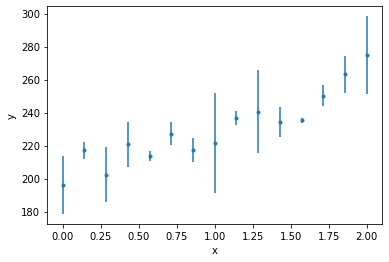

In [3]:
data_test=np.load("/Users/almagonzalez/Documents/cursos/DataAnalysis/DCIDA2020II/data/test_line.npy")
x,y,yerr=data_test
plt.errorbar(x,y,yerr,fmt='.')
plt.xlabel('x')
plt.ylabel('y')

In [4]:
yerr

array([17.68158841, -5.03133689, 16.58577924, 13.74440762,  2.87670665,
        6.82112915,  7.36724007, 30.33018382,  4.2901266 , 25.20427512,
       -9.21174822, -1.65378113, -6.43187287, 11.2999903 , 23.58489527])

De acuerdo con la gráfica arriba efectivamente un modelo de una recta, de la forma 

$y=m*x+b$

parece lo mas factible,
y debemos encontrar los valores de pendiente (m) y ordenada al origen (b). 

Basado en la gráfica podemos ver que los siguientes priors planos podrían ser usados: 

$100<b<300$

$0<m<100$

In [5]:
#definimos aquí todas las funciones a usar, i.e. modelo, posterior, likelihood, etc...

In [6]:
def linea(x,m,b):
    return m*x+b

In [73]:
def lnprior_(theta):
    m,b=theta
    if 0<m<100 and 100<b<300:
        return 0   #prior=1/(min-max)
    return -np.inf 

def lnlike_(theta,x,y,yerr):  #Gaussiano
    m,b=theta
    sigma2=yerr**2
    model=linea(x,m,b)
    llike=-0.5*np.sum((y-model)**2/sigma2)
    return llike
    
def lnpost_(theta,x,y,yerr):
    lnprior=lnprior_(theta)
    if not np.isfinite(lnprior):
        return -np.inf
    lnlike=lnlike_(theta,x,y,yerr)
    lnpost=lnlike+lnprior
    return lnpost

In [75]:
pos_ini=[50,200]

nwalkers,ndim = 32,2
chain_len=5000
pos = pos_ini+ 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost_,args=(data_test[0],data_test[1],data_test[2]))
sampler.run_mcmc(pos,chain_len, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 602.37it/s]


In [76]:
flat_samples = sampler.get_chain(discard=3000, flat=True)
print(flat_samples.shape)

(64000, 2)


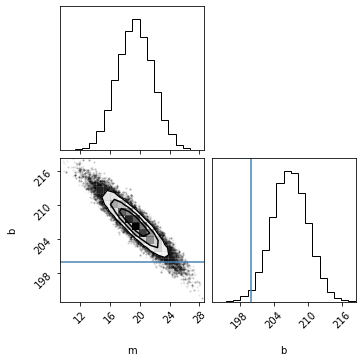

In [77]:
import corner
m_true,b_true,f_true=30,200,10
fig = corner.corner(
    flat_samples, labels=['m','b','f'], truths=[m_true, b_true,f_true]);

In [82]:
#Imprimimos el vlor medio y rango de confianza al 68%, encontrado con emcee. 

In [83]:
from IPython.display import display, Math

labels=["a","b"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Noten que los valores obtenidos no corresponden con los valores verdaderos, esto es porque los errores en nuestros datos no son simples, de hecho fueron generados añadiendo una componente completamente aleatoria. Probemos ver si nuestro ajuste mejora usando un modelo ligeramente diferente, con un nuevo parammetro libre que añadiremos a la varianza,de la siguiente forma. 

$\sigma^2= yerr^2+ (f*U(0,1))^2$

donde U(0,1) corresponde con una distribución uniforme. Para el nuevo parametro f tomare un prior amplio entre 0 y 50. No hay como tal un valor verdadero para f, pues no usé una forma del todo consiste en la generacíón de los errores. 

In [282]:
def lnprior_2(theta):
    m,b,f=theta
    if 0<m<100 and 100<b<300 and 0<f<20:
        return 0   #prior=1/(min-max)
    return -np.inf 

def lnlike_2(theta,x,y,yerr):  #Gaussiano
    m,b,f=theta
    sigma2=yerr**2+f**2
    model=linea(x,m,b)
    llike=-0.5*np.sum((y-model)**2/sigma2)
    return llike
    
def lnpost_2(theta,x,y,yerr):
    lnprior=lnprior_2(theta)
    if not np.isfinite(lnprior):
        return -np.inf
    lnlike=lnlike_2(theta,x,y,yerr)
    lnpost=lnlike+lnprior
    return lnpost

In [283]:
pos_ini=[50,150,5]

nwalkers,ndim = 32,3
chain_len=5000
pos = pos_ini+ 1e-4 * np.random.randn(nwalkers, ndim)

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnpost_2,args=(data_test[0],data_test[1],data_test[2]))
sampler2.run_mcmc(pos,chain_len, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 602.47it/s]


In [284]:
flat_samples2 = sampler2.get_chain(discard=3000, flat=True)
print(flat_samples2.shape)

(64000, 3)


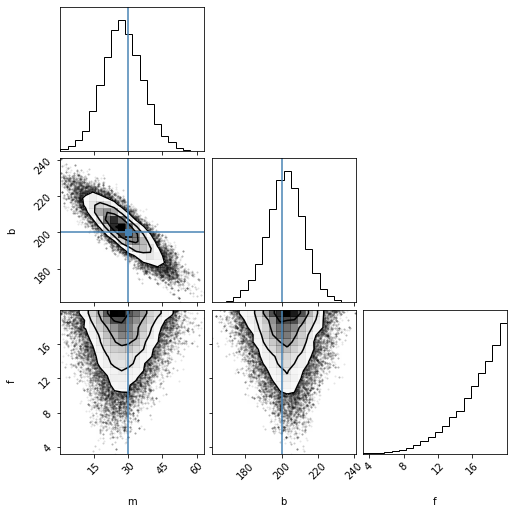

In [285]:
import corner
m_true,b_true,f_true=30,200,np.nan
fig = corner.corner(
    flat_samples2, labels=['m','b','f'], truths=[m_true, b_true,f_true]);

In [286]:
labels=["m","b","f"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Podemos ver ahora como nuestros parametros inferidos son mucho mejores, conteniendo el valor verdadero. El parametro f, realmente no tiene un significado para nosotros, el modelo que se usó para la varianza con ese parámetro libre no es exactamente lo se utilizó para generar los datos falsos. Pero ilustra el punto de que añadiendo un parámetro libre asociado a los errores se obtienen mejores intervalos de confianza para los parámetros de interes, m y b. El parámetro f se llama "nuissance", y en este caso nos sirvió para añadir una incertidumbre extra asociada a la varianza.  